# Save Results of all Models for a given Data and Model Version

Loop over all Folds and Models and save the results in a dataframe.  
Calculate a threshold for outcome prediction on the validation data (based on geometric mean) and apply it to the test data.  
Add a normalized prediction uncertainty based on the standard deviation of the predictions of the different models.  
Check the calibrartion plots.

## Load Libraries and Modules

In [1]:
#!pip install statsmodels
#!pip install seaborn

In [1]:
%matplotlib inline

import os
import h5py
import pandas as pd
import numpy as np

import time

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.proportion import proportion_confint
from sklearn.metrics import confusion_matrix
from sklearn import metrics

import tensorflow as tf
from tensorflow import keras

print("TF  Version",tf.__version__)

TF  Version 2.2.0


In [2]:
# check and set path before loading modules
print(os.getcwd())
DIR = "/tf/notebooks/schnemau/xAI_stroke_3d/"
if os.getcwd() != DIR:
    os.chdir(DIR)
    print(os.getcwd())

import functions_metrics as fm
import functions_model_definition as md
import functions_read_data as rdat

/tf
/tf/notebooks/schnemau/xAI_stroke_3d


## Load Data and Results

In [3]:
# Define Data Version (which splits and models)
version = "10Fold_sigmoid_V0" # one of the following (see ZZ_overview_of_runs.txt for details):
# 10Fold_sigmoid_V0, 10Fold_sigmoid_V1, 10Fold_sigmoid_V2, 10Fold_sigmoid_V2f, 10Fold_sigmoid_V3  
# 10Fold_softmax_V0, 10Fold_softmax_V1, andrea

# Define Model Version
model_version = 2

# should csv be saved?
save_file = False

DATA_OUTPUT_DIR = DIR + "data/"

In [4]:
# Setup the paths for the result assembly

## 10 Fold
if version.startswith("10Fold"):
    # Define the path + output path:

    DATA_DIR = DIR + "data/"
    WEIGHT_DIR = DIR + "weights/" + version + "/"

    # load data
    if version.endswith("V0") or version.endswith("sigmoid"):
        id_tab = pd.read_csv(DATA_DIR + "10Fold_ids_V0.csv", sep=",")
    elif version.endswith("V1"):
        id_tab = pd.read_csv(DATA_DIR + "10Fold_ids_V1.csv", sep=",")
    elif version.endswith("V2") or version.endswith("V2f"):
        id_tab = pd.read_csv(DATA_DIR + "10Fold_ids_V2.csv", sep=",")
    elif version.endswith("V3"):
        id_tab = pd.read_csv(DATA_DIR + "10Fold_ids_V3.csv", sep=",")
    X = np.load(DATA_DIR + "prepocessed_dicom_3d.npy")

    # define save name
    all_result_name = "all_tab_results_" + version + "_M" + str(model_version)

    # define splits
    which_splits = list(range(0,10)) # 10 Fold

    print(id_tab.shape)
    print(X.shape)

    
## Andrea 6 Split
elif version == "andrea":
    # Define the path + output path:

    IMG_DIR = "/tf/notebooks/hezo/stroke_zurich/data/" 
    DATA_DIR = "/tf/notebooks/hezo/stroke_zurich/data/" 
    WEIGHT_DIR = DIR + "weights/andrea_split/"

    # define data paths
    img_path = IMG_DIR + 'dicom_2d_192x192x3_clean_interpolated_18_02_2021_preprocessed2.h5'
    tab_path = IMG_DIR + 'baseline_data_zurich_prepared.csv'
    split_path = DIR + 'data/andrea_splits.csv'

    # define save name
    all_result_name = "all_tab_results_andrea_split"

    # # define splits
    which_splits = list(range(1,7)) # Andrea


(407, 14)
(407, 128, 128, 28)


In [5]:
print(WEIGHT_DIR)
print(all_result_name)

/tf/notebooks/schnemau/xAI_stroke_3d/weights/10Fold_sigmoid_V0/
all_tab_results_10Fold_sigmoid_V0_M2


In [6]:
## define model   
(input_dim, output_dim, LOSS, layer_connection, last_activation) = md.model_setup(version)
    

model_3d = md.stroke_binary_3d(input_dim = input_dim,
                               output_dim = output_dim,
                               layer_connection = layer_connection,
                               last_activation = last_activation)
model_3d.compile(
    loss=LOSS,
    optimizer=keras.optimizers.Adam(learning_rate=5*1e-5),
    metrics=["acc", tf.keras.metrics.AUC()]
)

# define if print should be enabled
check_print = True
        

In [7]:
# ## define model numbers
if version in ["andrea", "10Fold_sigmoid_V0", "10Fold_softmax_V0", 
               "10Fold_sigmoid_V2", "10Fold_sigmoid_V2f", "10Fold_sigmoid_V3"]:
    model_nrs = list(range(5))
elif version in ["10Fold_softmax_V1", "10Fold_sigmoid_V1"]:
    model_nrs = list(range(10))

# Define model name
generate_model_name = md.set_generate_model_name(
    model_version = model_version, 
    layer_connection = layer_connection, 
    last_activation = last_activation, 
    path = WEIGHT_DIR) 

In [8]:
results_list = [] # test dataset results
valid_list = [] # validation datset results

# loop over splits and models
start = time.time()
for which_split in which_splits:
    if check_print:
        print(" ")
        print("---- Start Reading Data of Split " + str(which_split) + " ----")
        print(" ")
    
    # 10 Fold
    if version.startswith("10Fold"):
        (X_train, X_valid, X_test), (y_train, y_valid, y_test) = rdat.split_data(id_tab, X, which_split)
        results = id_tab[id_tab["fold" + str(which_split)] == "test"].copy()
    
    # Andrea
    elif version == "andrea":
        (X_train, X_valid, X_test), (y_train, y_valid, y_test), results = rdat.read_and_split_img_data_andrea(
                path_img = img_path, 
                path_tab = tab_path, 
                path_splits = split_path, 
                split = which_split, 
                check_print = check_print)
           
    # add variable with current split
    results["test_split"] = which_split        
    
    # create new df for validation set, to calculate classification threshold 
    # => not cheating when calc on valid
    validation_results = pd.DataFrame(
        {"test_split": which_split,
         "unfavorable": y_valid}
    )
    
    if check_print:
        print(" ")
        print("---- Starting Result Calculation of Split " + str(which_split) + " ----")
        print(" ")
        
    y_test_preds = []
    y_valid_preds = []
     
    for model_nr in model_nrs:
        if check_print:
            print("Now calculating model nr. " + str(model_nr))
        
        model_3d.load_weights(generate_model_name(which_split, model_nr))
        
        if last_activation == "softmax":
            y_test_preds.append(model_3d.predict(X_test)[:,1].squeeze())
        else:
            y_test_preds.append(model_3d.predict(X_test).squeeze())
        results["y_pred_model_" + str(model_nr)] = y_test_preds[-1]
        
        if last_activation == "softmax":
            y_valid_preds.append(model_3d.predict(X_valid)[:,1].squeeze())
        else:
            y_valid_preds.append(model_3d.predict(X_valid).squeeze())
        validation_results["y_pred_model_" + str(model_nr)] = y_valid_preds[-1]
    
    y_test_preds = np.array(y_test_preds)
    results["y_pred_linear_avg"] = np.mean(y_test_preds, axis = 0)
    results["y_pred_trafo_avg"] = fm.sigmoid(np.mean(fm.inverse_sigmoid(y_test_preds), axis = 0))
    
    y_valid_preds = np.array(y_valid_preds)
    validation_results["y_pred_linear_avg"] = np.mean(y_valid_preds, axis = 0)
    validation_results["y_pred_trafo_avg"] = fm.sigmoid(np.mean(fm.inverse_sigmoid(y_valid_preds), axis = 0))
        
    results_list.append(results)
    valid_list.append(validation_results)
        
if check_print:
    end = time.time()
    print(" ")
    print("---- DONE ----")
    print(" ")   
    print("Duration of Execution: " + str(end-start))               
        

 
---- Start Reading Data of Split 0 ----
 
 
---- Starting Result Calculation of Split 0 ----
 
Now calculating model nr. 0
Now calculating model nr. 1
Now calculating model nr. 2
Now calculating model nr. 3
Now calculating model nr. 4
 
---- Start Reading Data of Split 1 ----
 
 
---- Starting Result Calculation of Split 1 ----
 
Now calculating model nr. 0
Now calculating model nr. 1
Now calculating model nr. 2
Now calculating model nr. 3
Now calculating model nr. 4
 
---- Start Reading Data of Split 2 ----
 
 
---- Starting Result Calculation of Split 2 ----
 
Now calculating model nr. 0
Now calculating model nr. 1
Now calculating model nr. 2
Now calculating model nr. 3
Now calculating model nr. 4
 
---- Start Reading Data of Split 3 ----
 
 
---- Starting Result Calculation of Split 3 ----
 
Now calculating model nr. 0
Now calculating model nr. 1
Now calculating model nr. 2
Now calculating model nr. 3
Now calculating model nr. 4
 
---- Start Reading Data of Split 4 ----
 
 
---- S

## Calculate Threshold

Calculation of threshold for classification is done on validation data. Then applied to the test data.

In [ ]:
# should threshold be calculated per split or over all?

 
---- Split 0 ----
 
Optimal Geometric Mean Threshold: 0.24510394
Accuracy to beat: 0.8048780487804879
Accuracy: 0.8048780487804879
Spezifität:  0.8181818181818181
Sensitivität:  0.75


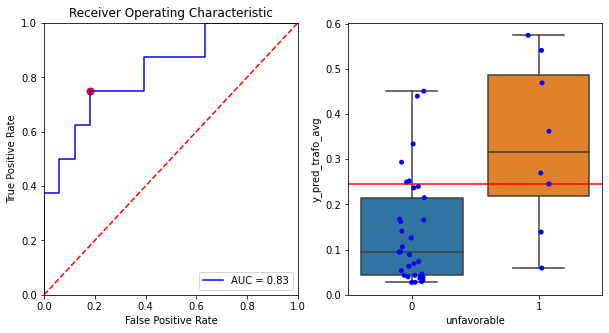

 
---- Split 1 ----
 
Optimal Geometric Mean Threshold: 0.1725957
Accuracy to beat: 0.8048780487804879
Accuracy: 0.7073170731707317
Spezifität:  0.6666666666666667
Sensitivität:  0.875


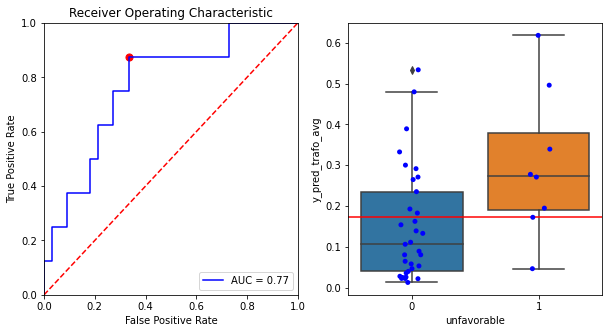

 
---- Split 2 ----
 
Optimal Geometric Mean Threshold: 0.33210385
Accuracy to beat: 0.825
Accuracy: 0.9
Spezifität:  0.9393939393939394
Sensitivität:  0.7142857142857143


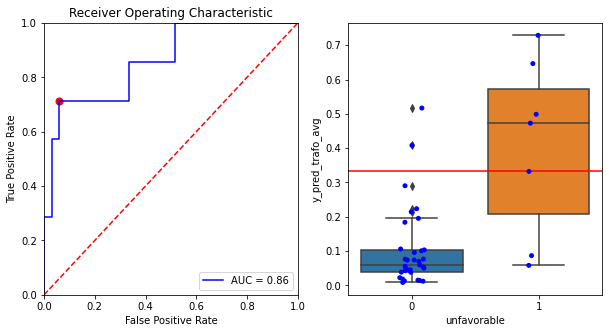

 
---- Split 3 ----
 
Optimal Geometric Mean Threshold: 0.1795399
Accuracy to beat: 0.825
Accuracy: 0.775
Spezifität:  0.7878787878787878
Sensitivität:  0.7142857142857143


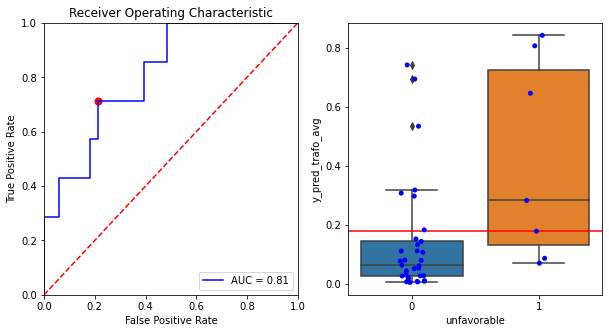

 
---- Split 4 ----
 
Optimal Geometric Mean Threshold: 0.18982704
Accuracy to beat: 0.825
Accuracy: 0.775
Spezifität:  0.8484848484848485
Sensitivität:  0.42857142857142855


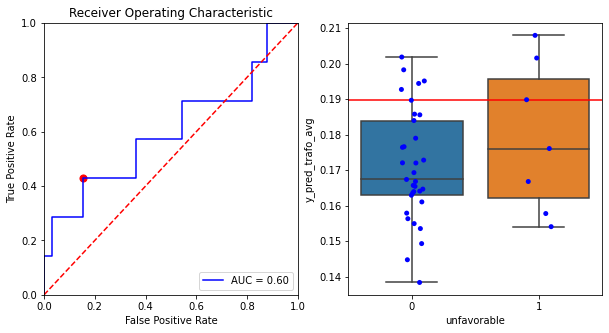

 
---- Split 5 ----
 
Optimal Geometric Mean Threshold: 0.20986369
Accuracy to beat: 0.8292682926829268
Accuracy: 0.8536585365853658
Spezifität:  0.8823529411764706
Sensitivität:  0.7142857142857143


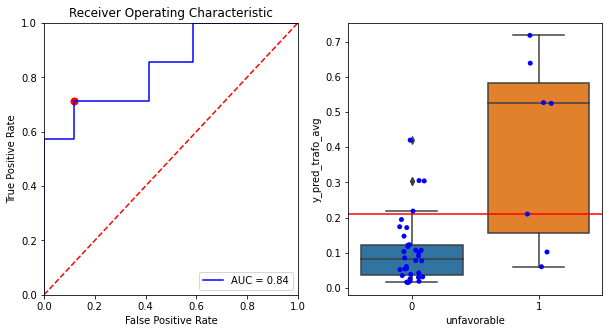

 
---- Split 6 ----
 
Optimal Geometric Mean Threshold: 0.19229293
Accuracy to beat: 0.8292682926829268
Accuracy: 0.7317073170731707
Spezifität:  0.7352941176470589
Sensitivität:  0.7142857142857143


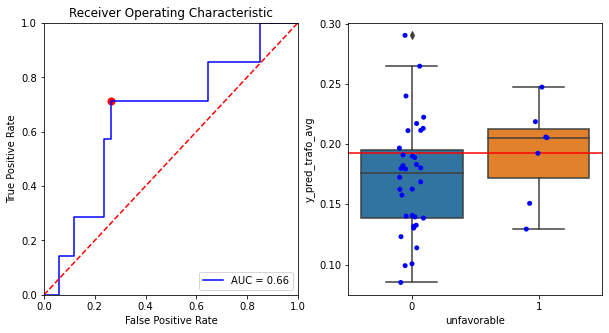

 
---- Split 7 ----
 
Optimal Geometric Mean Threshold: 0.14615345
Accuracy to beat: 0.8048780487804879
Accuracy: 0.8292682926829268
Spezifität:  0.7878787878787878
Sensitivität:  1.0


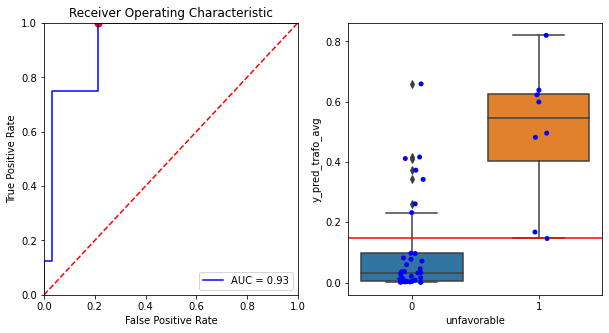

 
---- Split 8 ----
 
Optimal Geometric Mean Threshold: 0.19077285
Accuracy to beat: 0.8048780487804879
Accuracy: 0.6585365853658537
Spezifität:  0.696969696969697
Sensitivität:  0.5


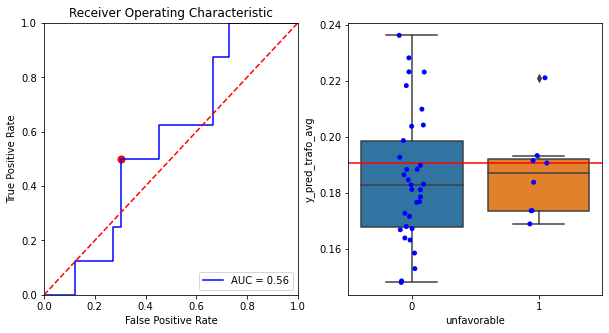

 
---- Split 9 ----
 
Optimal Geometric Mean Threshold: 0.21294926
Accuracy to beat: 0.8048780487804879
Accuracy: 0.7073170731707317
Spezifität:  0.696969696969697
Sensitivität:  0.75


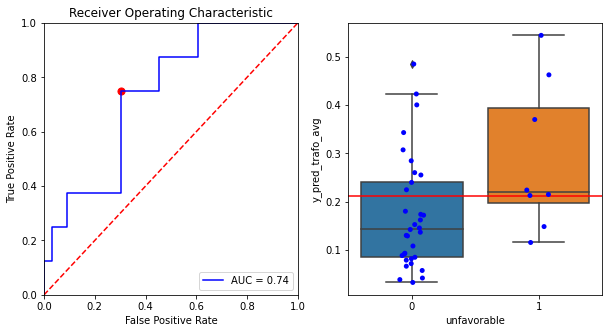

In [9]:
valid_thresholds = []

for i, validation_results in enumerate(valid_list):
    print(" ")
    print("---- Split " + str(which_splits[i]) + " ----")
    print(" ")
    
    y_org = validation_results["unfavorable"]
    y_pred = validation_results["y_pred_trafo_avg"]
    
    # calculate fpr, tpr and thresholds
    fpr, tpr, threshold = metrics.roc_curve(y_org, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    
    # calculate geometric mean of tpr and fpr to find best threshold
    gmean = np.sqrt(tpr * (1 - fpr))

    # Find the optimal threshold
    index = np.argmax(gmean)
    valid_thresholds.append(threshold[index])
    print("Optimal Geometric Mean Threshold: " + str(threshold[index]))
    
    # Calc Acc
    y_pred_label = (y_pred >= threshold[index]).squeeze()
    print("Accuracy to beat: " + str(1 - np.mean(y_org)))
    print("Accuracy: " + str(np.mean(y_pred_label == y_org)))
          
    print("Spezifität: ", 1-fpr[index])
    print("Sensitivität: ", tpr[index])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))
    
    # method I: plt
    ax1.title.set_text('Receiver Operating Characteristic')
    ax1.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    ax1.scatter(fpr[index], tpr[index], color = "red", s = 50)
    ax1.legend(loc = 'lower right')
    ax1.plot([0, 1], [0, 1],'r--')
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1])
    ax1.set_ylabel('True Positive Rate')
    ax1.set_xlabel('False Positive Rate')
    
    sns.boxplot(x = "unfavorable",
        y = "y_pred_trafo_avg",
        data = validation_results,
        ax = ax2)
    sns.stripplot(x = "unfavorable",
        y = "y_pred_trafo_avg",
        color = 'blue',
        data = validation_results,
        ax = ax2)
    ax2.axhline(y = threshold[index], color = "red")
    
    plt.show()

In [10]:
valid_thresholds

[0.24510394,
 0.1725957,
 0.33210385,
 0.1795399,
 0.18982704,
 0.20986369,
 0.19229293,
 0.14615345,
 0.19077285,
 0.21294926]

### Apply Threshold to Testdata

 
---- Split 0 ----
 
Accuracy to beat: 0.8292682926829268
Accuracy: 0.8292682926829268
Spezifität:  0.8529411764705882
Sensitivität:  0.7142857142857143


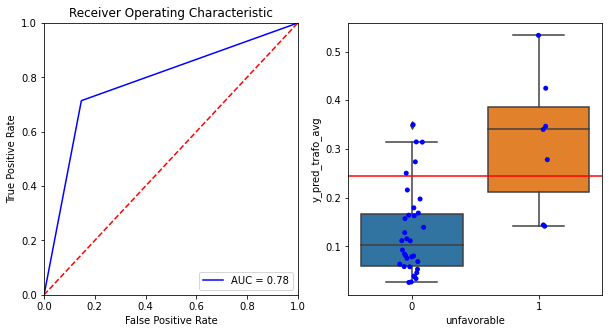

 
---- Split 1 ----
 
Accuracy to beat: 0.8292682926829268
Accuracy: 0.6585365853658537
Spezifität:  0.6764705882352942
Sensitivität:  0.5714285714285714


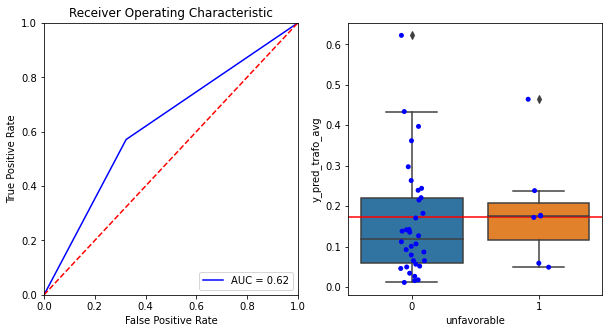

 
---- Split 2 ----
 
Accuracy to beat: 0.8048780487804879
Accuracy: 0.8048780487804879
Spezifität:  0.9090909090909091
Sensitivität:  0.375


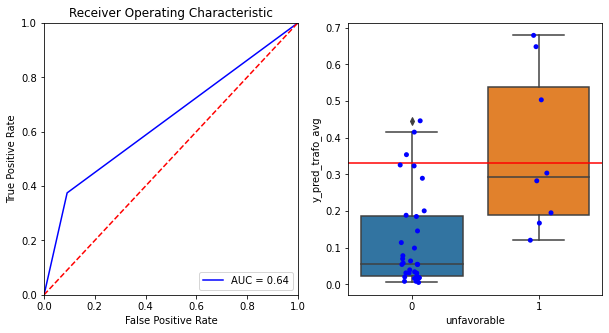

 
---- Split 3 ----
 
Accuracy to beat: 0.8048780487804879
Accuracy: 0.7317073170731707
Spezifität:  0.7272727272727273
Sensitivität:  0.75


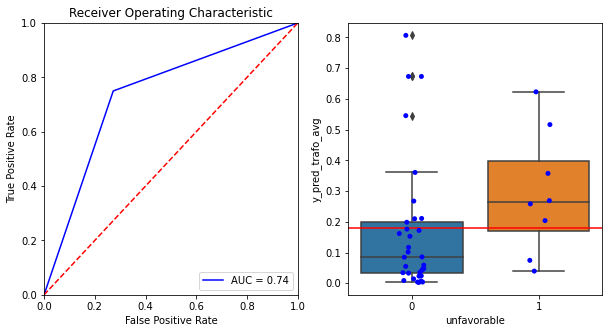

 
---- Split 4 ----
 
Accuracy to beat: 0.8048780487804879
Accuracy: 0.8048780487804879
Spezifität:  0.9393939393939394
Sensitivität:  0.25


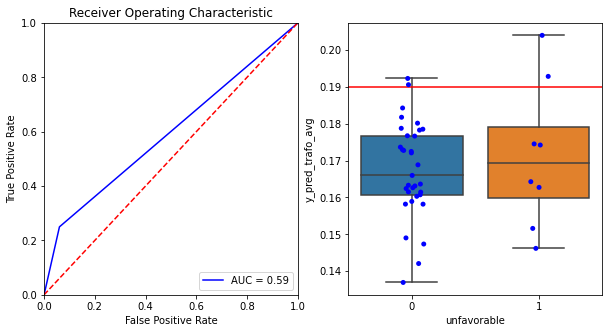

 
---- Split 5 ----
 
Accuracy to beat: 0.8048780487804879
Accuracy: 0.7560975609756098
Spezifität:  0.7878787878787878
Sensitivität:  0.625


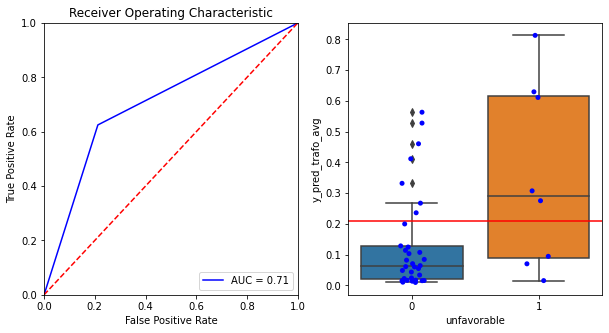

 
---- Split 6 ----
 
Accuracy to beat: 0.8048780487804879
Accuracy: 0.6829268292682927
Spezifität:  0.6666666666666667
Sensitivität:  0.75


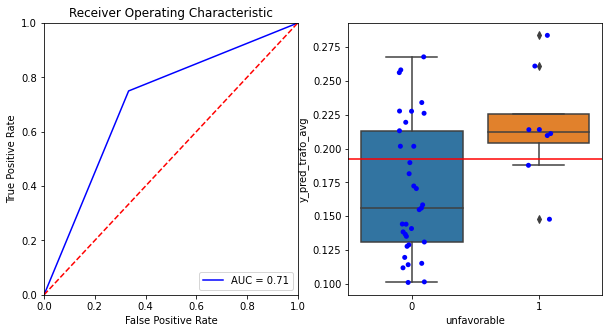

 
---- Split 7 ----
 
Accuracy to beat: 0.825
Accuracy: 0.875
Spezifität:  0.9090909090909091
Sensitivität:  0.7142857142857143


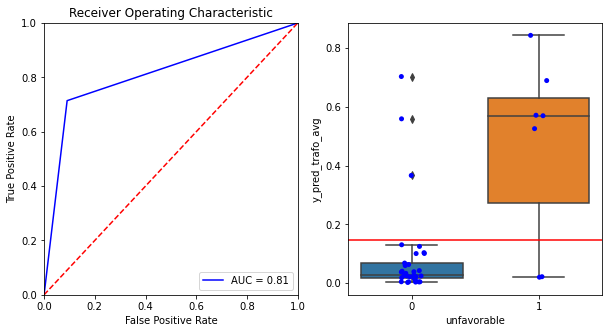

 
---- Split 8 ----
 
Accuracy to beat: 0.825
Accuracy: 0.625
Spezifität:  0.6666666666666667
Sensitivität:  0.42857142857142855


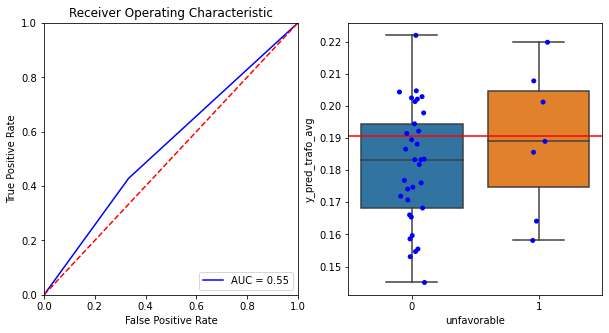

 
---- Split 9 ----
 
Accuracy to beat: 0.825
Accuracy: 0.675
Spezifität:  0.7272727272727273
Sensitivität:  0.42857142857142855


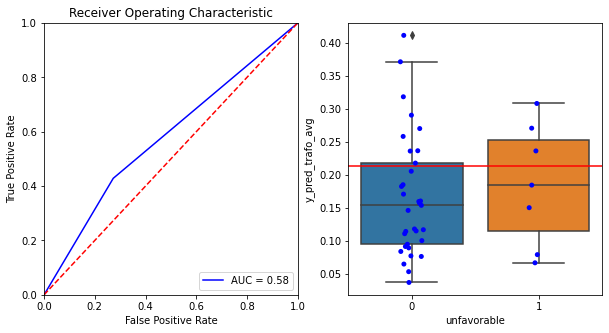

In [11]:
for i, results in enumerate(results_list):
    print(" ")
    print("---- Split " + str(which_splits[i]) + " ----")
    print(" ")

    results["threshold"] = valid_thresholds[i]
    results["y_pred_class"] = (results["y_pred_trafo_avg"] >= results["threshold"]).astype(int)
    
    y_org = results["unfavorable"]
    y_pred = results["y_pred_class"]
    
    # calculate fpr, tpr and thresholds
    fpr, tpr, threshold = metrics.roc_curve(y_org, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
      
    # Calc Acc
    print("Accuracy to beat: " + str(1 - np.mean(y_org)))
    print("Accuracy: " + str(np.mean(y_pred == y_org)))
          
    print("Spezifität: ", 1-fpr[1])
    print("Sensitivität: ", tpr[1])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))
    
    # method I: plt
    ax1.title.set_text('Receiver Operating Characteristic')
    ax1.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    ax1.legend(loc = 'lower right')
    ax1.plot([0, 1], [0, 1],'r--')
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1])
    ax1.set_ylabel('True Positive Rate')
    ax1.set_xlabel('False Positive Rate')
    
    sns.boxplot(x = "unfavorable",
        y = "y_pred_trafo_avg",
        data = results,
        ax = ax2)
    sns.stripplot(x = "unfavorable",
        y = "y_pred_trafo_avg",
        color = 'blue',
        data = results,
        ax = ax2)
    ax2.axhline(y = valid_thresholds[i], color = "red")
    
    plt.show()

#### Concat all Pandas and Analyze

In [12]:
all_results = pd.concat(results_list)
all_results.shape

(407, 24)

Accuracy to beat: 0.8157248157248157
Accuracy: 0.7444717444717445
Spezifität:  0.786144578313253
Sensitivität:  0.56


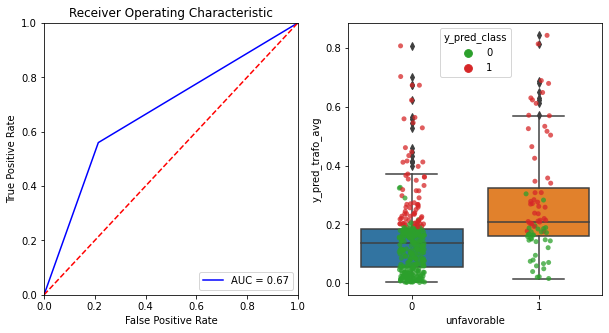

In [13]:
y_org = all_results["unfavorable"]
y_pred = all_results["y_pred_class"]

# calculate fpr, tpr and thresholds
fpr, tpr, threshold = metrics.roc_curve(y_org, y_pred)
roc_auc = metrics.auc(fpr, tpr)

# Calc Acc
y_pred_label = all_results["y_pred_class"]
print("Accuracy to beat: " + str(1 - np.mean(y_org)))
print("Accuracy: " + str(np.mean(y_pred_label == y_org)))

print("Spezifität: ", 1-fpr[1])
print("Sensitivität: ", tpr[1])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))

# method I: plt
ax1.title.set_text('Receiver Operating Characteristic')
ax1.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
ax1.legend(loc = 'lower right')
ax1.plot([0, 1], [0, 1],'r--')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax1.set_ylabel('True Positive Rate')
ax1.set_xlabel('False Positive Rate')

sns.boxplot(x = "unfavorable",
    y = "y_pred_trafo_avg",
    data = all_results,
    ax = ax2)
sns.stripplot(x = "unfavorable",
    y = "y_pred_trafo_avg",
    hue = 'y_pred_class',
    palette=["C2", "C3", "k"],
    data = all_results,
    alpha = 0.75,
    ax = ax2)
    

## Calculation of one threshold

1. Threshold based on all validation data. This makes not much sense as each fold has different models.
2. Threshold based on the validation data of each fold. This approach is used in the end.

threshold:  0.18982704
Accuracy to beat: 0.8157248157248157
Accuracy: 0.742014742014742
Spezifität:  0.7590361445783133
Sensitivität:  0.6666666666666666


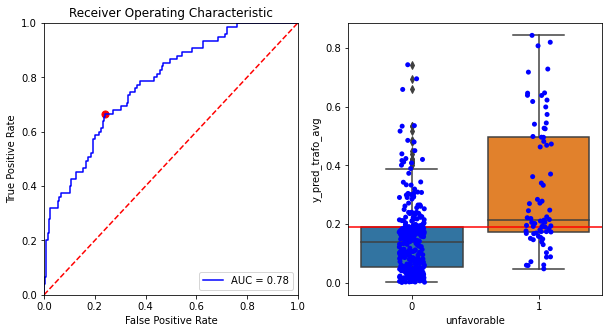

In [14]:
# 1.
all_valid_results = pd.concat(valid_list)

y_org = all_valid_results["unfavorable"]
y_pred = all_valid_results["y_pred_trafo_avg"]

fpr, tpr, threshold = metrics.roc_curve(y_org, y_pred)
roc_auc = metrics.auc(fpr, tpr)

# calculate geometric mean of tpr and fpr to find best threshold
gmean = np.sqrt(tpr * (1 - fpr))

# Find the optimal threshold
index = np.argmax(gmean)
valid_threshold = threshold[index]
print("threshold: ", threshold[index])


y_pred_label = (y_pred >= threshold[index]).squeeze()
print("Accuracy to beat: " + str(1 - np.mean(y_org)))
print("Accuracy: " + str(np.mean(y_pred_label == y_org)))

print("Spezifität: ", 1-fpr[index])
print("Sensitivität: ", tpr[index])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))

# method I: plt
ax1.title.set_text('Receiver Operating Characteristic')
ax1.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
ax1.scatter(fpr[index], tpr[index], color = "red", s = 50)
ax1.legend(loc = 'lower right')
ax1.plot([0, 1], [0, 1],'r--')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax1.set_ylabel('True Positive Rate')
ax1.set_xlabel('False Positive Rate')

sns.boxplot(x = "unfavorable",
    y = "y_pred_trafo_avg",
    data = all_valid_results,
    ax = ax2)
sns.stripplot(x = "unfavorable",
    y = "y_pred_trafo_avg",
    color = 'blue',
    data = all_valid_results,
    ax = ax2)
ax2.axhline(y = threshold[index], color = "red")

Accuracy to beat:     0.8157
Accuracy:             0.7297
-----------------[95% Conf.]-----------------
AUC of probabilities: 0.7324 [0.6672 0.7935]
NLL :                 0.4303
Threshold:            0.1898
Spezifität:           0.7651 [0.7166 0.8075]
Sensitivität:         0.5733 [0.4605 0.679 ]


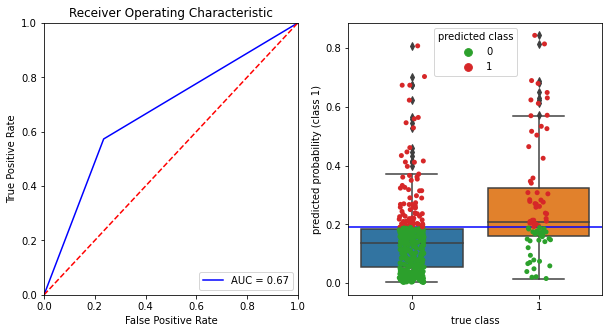

In [15]:
# 2.
all_results["threshold2"] = valid_threshold
all_results["y_pred_class2"] = (all_results["y_pred_trafo_avg"] >= all_results["threshold2"]).astype(int)

y_org = all_results["unfavorable"]
y_pred = all_results["y_pred_class2"]
y_pred_prob = all_results["y_pred_trafo_avg"]

# calculate fpr and tpr for probabilities
fpr_prob, tpr_prob, thresholds_prob = metrics.roc_curve(y_org, y_pred_prob)

# calculate fpr, tpr and thresholds for class
fpr, tpr, threshold = metrics.roc_curve(y_org, y_pred)
roc_auc = metrics.auc(fpr, tpr)

# calculate AUC confint
AUC0_CI = fm.compute_auc_ci(y_org, y_pred_prob)

# calculate spez and sens confint
cm = confusion_matrix(y_org, y_pred)
# sens
nobs = sum([cm[1,0],cm[1,1]])
count = sum([cm[1,1]])
sens_ci_low, sens_ci_upp = proportion_confint(count , nobs,  alpha=0.05, method='wilson')
#spec 
nobs = sum([cm[0,1],cm[0,0]])
count = sum([cm[0,0]])
spec_ci_low, spec_ci_upp = proportion_confint(count , nobs,  alpha=0.05, method='wilson')

# Calc Acc
print("Accuracy to beat:     " + str(round(1 - np.mean(y_org), 4)))
print("Accuracy:             " + str(round(np.mean(y_pred == y_org), 4)))
print("-----------------[95% Conf.]-----------------")

print("AUC of probabilities: " + str(round(metrics.auc(fpr_prob, tpr_prob), 4)) + " " +
                                 str(np.around([AUC0_CI[0], AUC0_CI[1]],4)))
print("NLL :                 " + str(round(metrics.log_loss(y_org, y_pred_prob), 4)))

print("Threshold:            " + str(round(valid_threshold, 4)))

print("Spezifität:           " + str(round(1-fpr[1], 4)) + " " +
                                 str(np.around([spec_ci_low, spec_ci_upp],4)))
print("Sensitivität:         " + str(round(tpr[1], 4)) + " " +
                                 str(np.around([sens_ci_low, sens_ci_upp],4)))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))

# method I: plt
ax1.title.set_text('Receiver Operating Characteristic')
ax1.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
ax1.legend(loc = 'lower right')
ax1.plot([0, 1], [0, 1],'r--')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax1.set_ylabel('True Positive Rate')
ax1.set_xlabel('False Positive Rate')

sns.boxplot(x = "unfavorable",
    y = "y_pred_trafo_avg",
    data = all_results,
    ax = ax2)
sns.stripplot(x = "unfavorable",
    y = "y_pred_trafo_avg",
    hue = 'y_pred_class2',
    palette=["C2", "C3"],
    data = all_results,
    ax = ax2)
plt.legend(title='predicted class', loc='upper center')
ax2.set(xlabel='true class', ylabel='predicted probability (class 1)')
ax2.axhline(y = valid_threshold, color = "blue")

In [16]:
all_results

,p_idx,p_id,mrs,unfavorable,fold0,fold1,fold2,fold3,fold4,fold5,...,y_pred_model_1,y_pred_model_2,y_pred_model_3,y_pred_model_4,y_pred_linear_avg,y_pred_trafo_avg,threshold,y_pred_class,threshold2,y_pred_class2
13,14,21,1.0,0,test,train,train,train,train,val,...,0.030385,0.029033,0.033630,0.012902,0.028426,0.026853,0.245104,0,0.189827,0
26,27,36,0.0,0,test,train,train,train,train,val,...,0.151121,0.160399,0.163338,0.168890,0.162887,0.162765,0.245104,0,0.189827,0
27,28,38,2.0,0,test,train,train,train,train,val,...,0.134079,0.201053,0.173100,0.198339,0.180561,0.179002,0.245104,0,0.189827,0
33,34,44,1.0,0,test,train,train,train,train,val,...,0.309629,0.327560,0.271382,0.331109,0.314483,0.313987,0.245104,1,0.189827,1
34,35,46,0.0,0,test,train,train,train,train,val,...,0.021926,0.036492,0.030993,0.013641,0.027342,0.025820,0.245104,0,0.189827,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,345,486,0.0,0,train,train,train,train,val,train,...,0.232157,0.344927,0.415975,0.489706,0.375858,0.371074,0.212949,1,0.189827,1
369,370,514,3.0,1,train,train,train,train,val,train,...,0.205495,0.212241,0.109984,0.124774,0.155006,0.150044,0.212949,0,0.189827,0
393,394,541,0.0,0,train,train,train,train,val,train,...,0.220079,0.279492,0.061136,0.193183,0.166490,0.145909,0.212949,0,0.189827,0
396,397,546,1.0,0,train,train,train,train,val,train,...,0.180939,0.150890,0.036138,0.064971,0.093762,0.076150,0.212949,0,0.189827,0


In [17]:
# Check 10 choosen patients which are also in andreas split 6 
all_results[all_results.p_id.isin([27,35,125,297,299,319,460,481,483,529])
            ][["p_id", "mrs", "unfavorable", "test_split", 
               "y_pred_model_" + "0", "y_pred_model_" + "1", 
               "y_pred_model_" + "2", "y_pred_model_" + "3", 
               "y_pred_model_" + "4", 
               "y_pred_trafo_avg", "y_pred_class"]].sort_values(by = "p_id")


,p_id,mrs,unfavorable,test_split,y_pred_model_0,y_pred_model_1,y_pred_model_2,y_pred_model_3,y_pred_model_4,y_pred_trafo_avg,y_pred_class
19,27,2.0,0,2,0.332215,0.464873,0.344435,0.499510,0.443939,0.415340,1
25,35,0.0,0,3,0.042533,0.031784,0.035697,0.044963,0.021773,0.034305,0
85,125,0.0,0,2,0.037880,0.018277,0.007411,0.031848,0.011892,0.018163,0
213,297,4.0,1,2,0.307124,0.342957,0.256038,0.246602,0.266685,0.282570,0
215,299,4.0,1,8,0.163877,0.173809,0.170605,0.175152,0.139525,0.164141,0
234,319,3.0,1,9,0.313084,0.228074,0.293222,0.285420,0.438642,0.307927,1
323,460,4.0,1,6,0.190672,0.252899,0.193766,0.222059,0.193509,0.209634,1
340,481,0.0,0,8,0.161269,0.178307,0.161725,0.178952,0.119470,0.158610,0
342,483,6.0,1,9,0.121337,0.223706,0.259137,0.100630,0.274055,0.184256,0
384,529,5.0,1,1,0.166496,0.235819,0.169582,0.117142,0.188150,0.172021,0


## Calculate Model Uncertainty

Use the standard deviation of the predictions as a measure of uncertainty. Then use min max normalization to scale the uncertainty between 0 and 1.  
Compare the uncertainty with the predictions

In [18]:
all_results["y_pred_std"] = all_results[["y_pred_model_" + str(i) for i in range(5)]].std(axis = 1)
all_results["y_pred_unc"] = (all_results["y_pred_std"] - all_results.y_pred_std.min()) / (
    all_results.y_pred_std.max() - all_results.y_pred_std.min())

[Text(0, 0.5, 'prediction uncertainty'), Text(0.5, 0, 'true class')]

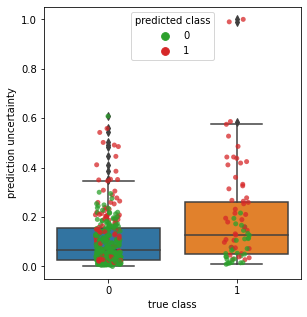

In [19]:
# Plot uncertainty
plt.figure(figsize = (4.6,5))
sns.boxplot(x = "unfavorable",
    y = "y_pred_unc",
    data = all_results)
g = sns.stripplot(x = "unfavorable",
    y = "y_pred_unc",
    hue = 'y_pred_class2',
    alpha = 0.75,
    palette=["C2", "C3"],
    data = all_results)
plt.legend(title='predicted class', loc='upper center')
g.set(xlabel='true class', ylabel='prediction uncertainty')

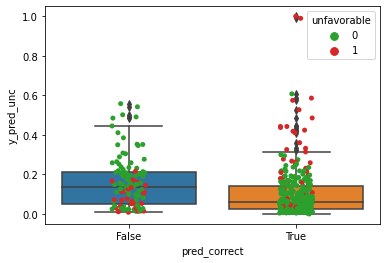

In [20]:
all_results["pred_correct"] = all_results["y_pred_class2"] == all_results["unfavorable"] 

sns.boxplot(x = "pred_correct",
    y = "y_pred_unc",
    data = all_results)
sns.stripplot(x = "pred_correct",
    y = "y_pred_unc",
    hue = 'unfavorable',
    palette=["C2", "C3"],
    data = all_results)

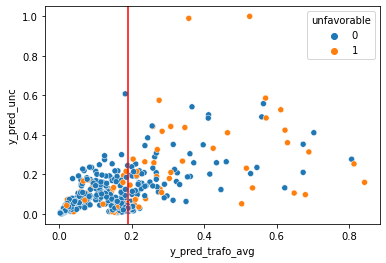

In [21]:
sns.scatterplot(
           x = "y_pred_trafo_avg",
           y = "y_pred_unc",
           hue = "unfavorable",
           data = all_results)
plt.axvline(x = valid_threshold, color = "red")

### Save results

Delete threshold 1 because mulitple different thresholds does not make sense.

In [22]:
all_results = all_results.drop(columns = ["y_pred_class", "threshold"])
all_results = all_results.rename(columns = {"y_pred_class2": "y_pred_class", "threshold2": "threshold"})

In [ ]:
if save_file:
    all_results.to_csv(DATA_OUTPUT_DIR + all_result_name + ".csv",  index=False) # rename output file!!!!

In [23]:
all_result_name

'all_tab_results_10Fold_sigmoid_V0_M2'

# Check Splits

Only used for andreas/paper split:  
Shows the different predictions (and uncertainties) for patients which were in multiple test splits.

In [ ]:
if version == "andrea":    
    andrea_splits = pd.read_csv(split_path, 
                                    sep='\,', header = None, engine = 'python', 
                                    usecols = [1,2,3]).apply(lambda x: x.str.replace(r"\"",""))
    andrea_splits.columns = andrea_splits.iloc[0]
    andrea_splits.drop(index=0, inplace=True)
    andrea_splits = andrea_splits.astype({'idx': 'int32', 'spl': 'int32'})
    print(andrea_splits[andrea_splits["type"].isin(["test"])].idx.nunique())
    print(sum(andrea_splits["type"].isin(["test"])))

In [ ]:
if version == "andrea":
    all_p_dup = all_results[all_results["p_id"].duplicated()]["p_id"].unique()
    all_dup = all_results[all_results["p_id"].isin(all_p_dup)].sort_values("p_id")
    all_dup["p_id"].value_counts().value_counts()

In [ ]:
if version == "andrea":
    print("Total duplicate: ", len(all_dup["p_id"].value_counts()))

    print("gleich klassifieziert (%): ", np.mean(all_dup.groupby("p_id").y_pred_class.mean().isin([0,1])))
    print("gleich klassifieziert (abs): ", np.sum(all_dup.groupby("p_id").y_pred_class.mean().isin([0,1])))

In [ ]:
if version == "andrea":
    sns.histplot(all_dup.groupby("p_id").y_pred_trafo_avg.std())

In [ ]:
if version == "andrea":
    all_dup

## Calibration Plot

Plot the calibration of all models and the mean calibration.

In [24]:
cal_plot_datas = []
for split in which_splits:
    dat = all_results.loc[all_results["test_split"] == split]
    cal_plot_datas.append(fm.cal_plot_data_prep(
        dat["y_pred_trafo_avg"].array, dat["unfavorable"].array
    ).select_dtypes(include=np.number))

In [25]:
all_cal_plot_datas = pd.concat(cal_plot_datas)
all_cal_plot_datas["iter"] = all_cal_plot_datas.index
all_cal_plot_datas = all_cal_plot_datas.groupby("iter")[
    ["predicted_probability_middle", "observed_proportion", "observed_proportion_lower", "observed_proportion_upper"]].mean()

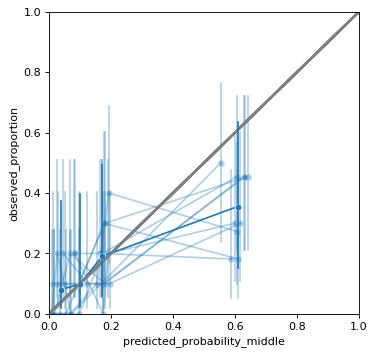

In [26]:
from matplotlib.pyplot import figure
figure(figsize=(5, 5), dpi=80)

for i in range(len(which_splits)):
    fm.cal_plot(cal_plot_datas[i], 
             "predicted_probability_middle", "observed_proportion",
                        "observed_proportion_lower", "observed_proportion_upper", alpha = .35, show = False)
fm.cal_plot(all_cal_plot_datas, "predicted_probability_middle", "observed_proportion",
                        "observed_proportion_lower", "observed_proportion_upper")

## Check Volume index

Check if X_test is the same when selected via p_idx as when directly selected.  
This must be true to make sure the correct volume is accessed for the heatmaps.

In [ ]:
with h5py.File("/tf/notebooks/hezo/stroke_zurich/data/dicom_2d_192x192x3_clean_interpolated_18_02_2021_preprocessed2.h5", "r") as h5:
# both images are the same
    X_in = h5["X"][:]
    Y_img = h5["Y_img"][:]
    Y_pat = h5["Y_pat"][:]
    pat = h5["pat"][:]

In [ ]:
index = 0
results.p_id.array[0]

In [ ]:
np.argwhere(pat == results.p_id.array[index]).squeeze()

In [ ]:
im1 = X_test[index].astype("float64")
im2 = X_in[np.argwhere(pat == results.p_id.array[index]).squeeze()].astype("float64")
np.allclose(im1, im2)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(im1[:,:,14])
ax2.imshow(im2[:,:,14])